## Libraries

In [18]:
from PIL import Image
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
import torch

torch.cuda.empty_cache()

## Loading the model

In [3]:
model_id = "llava-hf/llava-1.5-7b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
).to(0)

processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Test on a random image from the generated ones

4_cat.png


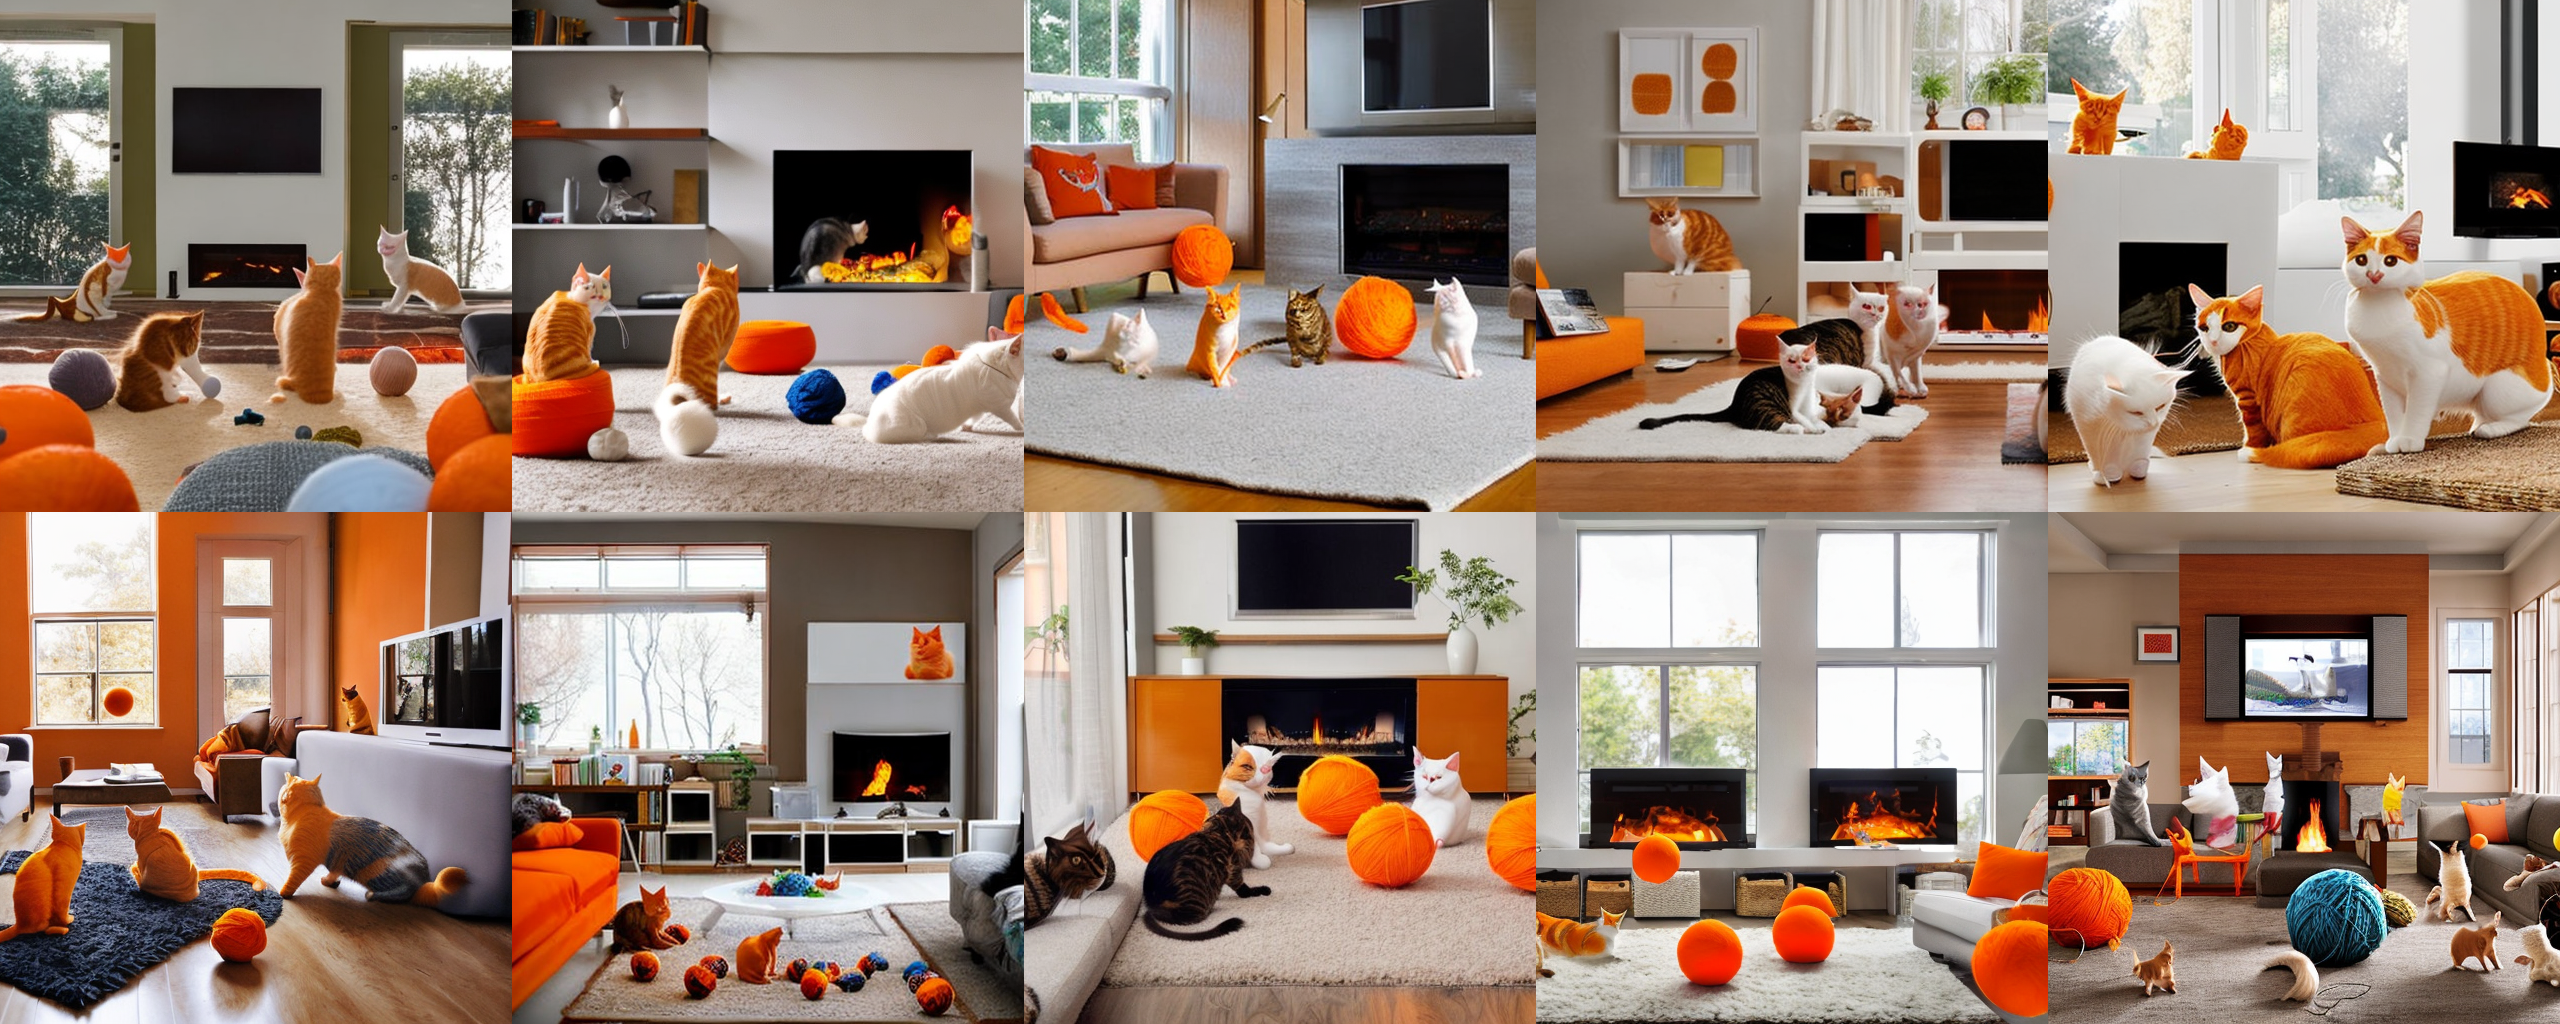

In [10]:
import random
import os

image_files = [f for f in os.listdir('../generative_images/') if f.endswith(('.png', '.jpg', '.jpeg'))]

image = Image.open(os.path.join('../generative_images/', random.choice(image_files)))
print(random.choice(image_files))
image

## subdivide the grouped images into single ones

In [11]:
def extract_images_from_grid(grid, rows, cols):
    images = []
    for i in range(rows):
        for j in range(cols):
            box = (j * grid.width // cols, i * grid.height // rows, (j + 1) * grid.width // cols, (i + 1) * grid.height // rows)
            images.append(grid.crop(box))
    return images

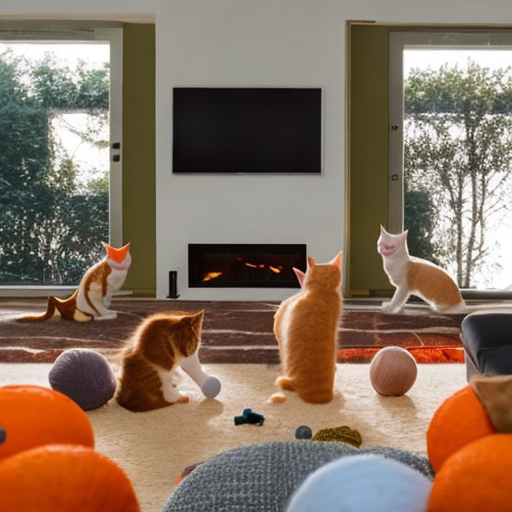

In [12]:
extracted_imgs = extract_images_from_grid(image, 2, 5)
extracted_imgs[0]

## LlaVa interpretation

In [17]:
prompt = "USER: <image>\nGenerate very detailed scene description of the image. In a very consistent and detailed sentence, describe the finest possible details the scene. The image main element and center focus as well as the background. Don't forget the number of elements you see, the colors and enything worth mentionning. use the following description as template: 'A polar bear mother and her two cubs playing on a chunk of ice in the Arctic sea. The mother bear's thick, white fur is covered in snow and ice, and her sharp claws dig into the ice. The cubs' fur is soft and white, and they playfully wrestle with each other. In the background, a family of walruses lounges on the ice.'. Start directly describing the image and avoid discussion, notes or suggestions. \nASSISTANT: \n"

inputs = processor(prompt, extracted_imgs[0], return_tensors='pt').to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=512*8, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))

ER:  
Generate very detailed scene description of the image. In a very consistent and detailed sentence, describe the finest possible details the scene. The image main element and center focus as well as the background. Don't forget the number of elements you see, the colors and enything worth mentionning. use the following description as template: 'A polar bear mother and her two cubs playing on a chunk of ice in the Arctic sea. The mother bear's thick, white fur is covered in snow and ice, and her sharp claws dig into the ice. The cubs' fur is soft and white, and they playfully wrestle with each other. In the background, a family of walruses lounges on the ice.'. Start directly describing the image and avoid discussion, notes or suggestions. 
ASSISTANT: 

In the image, there is a group of cats sitting on a rug in a living room. There are five cats in total, with one sitting on the left side of the rug, two cats in the middle, and two more cats on the right side. The cats are of vario

## Loop over the 10 images

In [16]:
for i in range(10):
    print(f"\nimage {i+1}\#\-------------------/#/\n")
    inputs = processor(prompt, extracted_imgs[i], return_tensors='pt').to(0, torch.float16)

    output = model.generate(**inputs, max_new_tokens=512*8, do_sample=False)
    print(processor.decode(output[0][2:], skip_special_tokens=True))



image 1\-------------------//

ER:  
Generate very detailed scene description of the image. In a very consistent and detailed sentence, describe the finest possible details the scene. The image main element and center focus as well as the background. Don't forget the number of elements you see, the colors and enything worth mentionning. use the following description as template: A polar bear mother and her two cubs playing on a chunk of ice in the Arctic sea. The mother bear's thick, white fur is covered in snow and ice, and her sharp claws dig into the ice. The cubs' fur is soft and white, and they playfully wrestle with each other. In the background, a family of walruses lounges on the ice. 
ASSISTANT: 

In the image, there is a group of cats sitting on a rug in a living room. There are a total of five cats, with one sitting on the left side of the rug, two cats in the middle, and two more cats on the right side. The cats are of various sizes, with some being larger and others small